In [1]:
from src.Funciones import *
from matplotlib.patches import Polygon

In [2]:
def buscaEsquina(m, j, e1, e2):
    ind = -1
    val = (10.0)**300
    for i in range(8):
        if not(i==e1 or i==e2):
            if (m[i][j]>0):
                c = m[i][10]/m[i][j]
                if c < val:
                    val = c
                    ind = i
    return ind
def opera(m,e,s):
    m[s] = m[s]/(m[s][e])
    for i in range(8):
        if i!=s:
            piv=m[i][e]
            m[i] = m[i]-(m[s]*piv)

def pmat(m):
    for i in range(len(m)):
        lin = ""
        for j in range(len(m[0])):
            lin = lin+"\t"+str(round(m[i][j],2))
        print(lin)
    print("")
    
def calcVerticesFBZ(b1, b2):
    pts = []
    vecinos=[m2V(b1,b2,( 1, 0)),m2V(b1,b2,( 1, 1)),
             m2V(b1,b2,( 0, 1)),m2V(b1,b2,(-1, 1)),
             m2V(b1,b2,(-1, 0)),m2V(b1,b2,(-1,-1)),
             m2V(b1,b2,( 0,-1)),m2V(b1,b2,( 1,-1))]
    # Creamos el espacio para la matriz en que operaremos
    v = np.array(vecinos)
    eq = np.zeros((8,11))
    et = ["V1","V2","V3","V4","V5","V6","V7","V8"]
    xy = [10,10]
    cruce = [-1,-1]
    # Damos los valores correspondientes
    for i in range(8):
        eq[i][i] = 1
        eq[i][8] = 2*v[i][0]
        eq[i][9] = 2*v[i][1]
        eq[i][10] = (v[i][0]**2) + (v[i][1]**2)
    pmat(eq)
    # Entra valor de X
    ind = buscaEsquina(eq,8,xy[0],xy[1])
    xy[0]=ind
    cruce[0]=ind
    opera(eq,8,ind)
    # Entra valor de Y
    ind = buscaEsquina(eq,9,xy[0],xy[1])
    xy[1]=ind
    cruce[1]=ind
    opera(eq,9,ind)
    p = (round(eq[xy[0]][10],10),round(eq[xy[1]][10],10))
    pts.append(p)
    pmat(eq)
    cont=0
    while True:
        cont+=1
        e = cruce[0]
        s = buscaEsquina(eq,e,xy[0],xy[1])
        opera(eq,e,s)
        pmat(eq)
        cruce[0] = cruce[1]
        cruce[1] = s
        p2 = (round(eq[xy[0]][10],10),round(eq[xy[1]][10],10))
        if p2!=p:
            if p2==pts[0]:
                break
            p=p2
            pts.append(p)
        if cont>10:
            break
    
    return pts, eq


In [3]:
m1 = grafeno()

In [4]:
a, eq=calcVerticesFBZ(to2D(m1.reciprocalVectors[0]),to2D(m1.reciprocalVectors[1]))

	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	2.58	1.49	2.21
	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	2.58	-1.49	2.21
	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	-2.97	2.21
	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	-2.58	-4.46	6.63
	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	-2.58	-1.49	2.21
	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	-2.58	1.49	2.21
	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	2.97	2.21
	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	2.58	4.46	6.63

	0.39	0.0	0.0	0.0	0.0	0.0	-0.19	0.0	1.0	0.0	0.43
	-1.0	1.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	2.21
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	4.42
	1.0	0.0	0.0	1.0	0.0	0.0	1.0	0.0	0.0	0.0	11.05
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	4.42
	1.0	0.0	0.0	0.0	0.0	1.0	-1.0	0.0	0.0	0.0	2.21
	0.0	0.0	0.0	0.0	0.0	0.0	0.34	0.0	0.0	1.0	0.74
	-1.0	0.0	0.0	0.0	0.0	0.0	-1.0	1.0	0.0	0.0	2.21

	0.0	0.0	0.0	0.0	0.0	-0.39	0.19	0.0	1.0	0.0	-0.43
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	4.42
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	4.42
	0.0	0.0	0.0	1.0	0.0	-1.0	2.0	0.0	0.0	0.0	8.84
	0.0	0.0	0.0	0.0	1.0	-1.0	1.0	0.0	0.0	0.0	2

In [5]:
'''ax = plt.subplot()
hexa=Polygon(a,alpha=0.3, color = 'red')
ax.add_patch(hexa)
ax.autoscale_view(True)'''

"ax = plt.subplot()\nhexa=Polygon(a,alpha=0.3, color = 'red')\nax.add_patch(hexa)\nax.autoscale_view(True)"

In [6]:
m2 = grafeno().mRot(32.2)
a2, eq2=calcVerticesFBZ(to2D(m2.reciprocalVectors[0]),to2D(m2.reciprocalVectors[1]))

	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.39	2.63	2.21
	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	2.97	0.11	2.21
	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	1.58	-2.52	2.21
	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.2	-5.15	6.63
	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	-1.39	-2.63	2.21
	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	-2.97	-0.11	2.21
	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	-1.58	2.52	2.21
	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	-0.2	5.15	6.63

	0.39	-0.18	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.46
	-0.01	0.34	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.73
	1.0	-1.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	2.21
	2.0	-1.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	8.84
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	4.42
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	4.42
	-1.0	1.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	2.21
	-2.0	1.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	4.42

	0.21	0.0	0.0	0.0	0.0	0.0	0.18	0.0	0.0	1.0	0.86
	0.33	0.0	0.0	0.0	0.0	0.0	-0.34	0.0	1.0	0.0	-0.03
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	4.42
	1.0	0.0	0.0	1.0	0.0	0.0	1.0	0.0	0.0	0.0	11.05
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.

In [7]:
m3 = superMesh((8.540000000000001, -2.1131019852340303), (-2.44, 8.452407940936121),[m1,m2])
a3, eq3=calcVerticesFBZ(to2D(m3.reciprocalVectors[0]),to2D(m3.reciprocalVectors[1]))

	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.79	0.23	0.17
	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.59	-0.57	0.17
	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	-0.2	-0.8	0.17
	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	-0.99	-1.03	0.51
	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	-0.79	-0.23	0.17
	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	-0.59	0.57	0.17
	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.2	0.8	0.17
	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.99	1.03	0.51

	1.36	0.0	0.0	0.0	0.0	0.0	-0.39	0.0	1.0	0.0	0.17
	-1.0	1.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.17
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.34
	1.0	0.0	0.0	1.0	0.0	0.0	1.0	0.0	0.0	0.0	0.85
	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.34
	1.0	0.0	0.0	0.0	0.0	1.0	-1.0	0.0	0.0	0.0	0.17
	-0.34	0.0	0.0	0.0	0.0	0.0	1.35	0.0	0.0	1.0	0.17
	-1.0	0.0	0.0	0.0	0.0	0.0	-1.0	1.0	0.0	0.0	0.17

	0.0	0.0	0.0	0.0	0.0	-1.36	0.97	0.0	1.0	0.0	-0.07
	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.34
	0.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.34
	0.0	0.0	0.0	1.0	0.0	-1.0	2.0	0.0	0.0	0.0	0.68
	0.0	0.0	0.0	0.0	1.0	-1.0	1.0	0.0	0.0	0.0	0

In [38]:
t=10
xs=[]
ys=[]
enls=[]
sra,srb=to2D(m3.reciprocalVectors[0]),to2D(m3.reciprocalVectors[1])
for i in range(-4,4):
    for j in range(-4,4):
        (px,py) = m2V(sra,srb,(i,j))
        xs.append(px)
        ys.append(py)
        o=sumaV((px,py),a3[len(a3)-1])
        for p in a3:
            f=sumaV((px,py),p)
            enls.append([o,f])
            o=f
xs=np.array(xs)
ys=np.array(ys)
le = mc.LineCollection(np.array(enls), colors='silver', linewidths=(t/10))

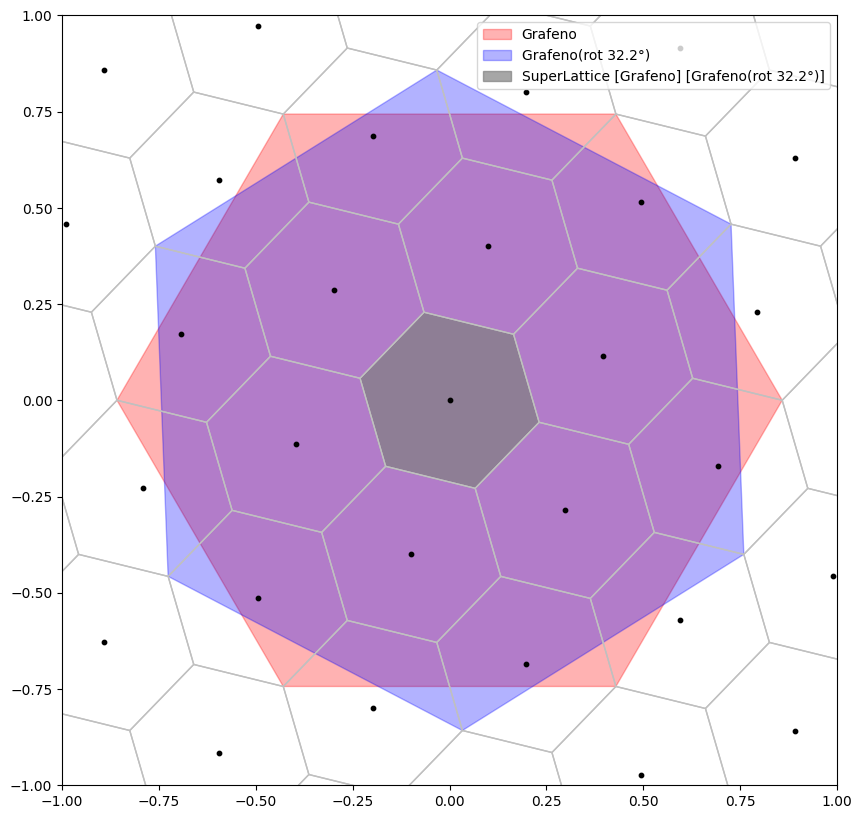

In [39]:
ax = plt.subplot()
hexa1=Polygon(a,alpha=0.3, color = 'red', label = m1.name)
ax.add_patch(hexa1)
hexa2=Polygon(a2,alpha=0.3, color = 'blue', label = m2.name)
ax.add_patch(hexa2)
hexa3=Polygon(a3,alpha=0.7, color = 'gray', label = m3.name)
ax.add_patch(hexa3)
ax.add_collection(le)
ax.scatter(xs,ys, color='black',s=t)
ax.set(xlim=(-1.0,1.0), ylim=(-1.0,1.0))
ax.legend(loc = 'upper right')
plt.show()

In [13]:
a3

[(0.1650689709, 0.1715447066),
 (-0.0660275883, 0.2287262754),
 (-0.2310965592, 0.0571815689),
 (-0.1650689709, -0.1715447066),
 (0.0660275883, -0.2287262754),
 (0.2310965592, -0.0571815689)]

In [21]:
enls

[[(-0.9574000310609554, 1.0864498082968588),
  (-1.0234276193609555, 1.3151760837968587)],
 [(-1.0234276193609555, 1.3151760837968587),
  (-1.2545241785609553, 1.3723576525968588)],
 [(-1.2545241785609553, 1.3723576525968588),
  (-1.4195931494609555, 1.2008129460968586)],
 [(-1.4195931494609555, 1.2008129460968586),
  (-1.3535655611609554, 0.9720866705968587)],
 [(-1.3535655611609554, 0.9720866705968587),
  (-1.1224690019609556, 0.9149051017968587)],
 [(-1.1224690019609556, 0.9149051017968587),
  (-0.9574000310609554, 1.0864498082968588)],
 [(-1.0564414135827018, 0.686178826277958),
  (-1.122469001882702, 0.914905101777958)],
 [(-1.122469001882702, 0.914905101777958),
  (-1.3535655610827018, 0.9720866705779581)],
 [(-1.3535655610827018, 0.9720866705779581),
  (-1.518634531982702, 0.8005419640779581)],
 [(-1.518634531982702, 0.8005419640779581),
  (-1.4526069436827018, 0.5718156885779581)],
 [(-1.4526069436827018, 0.5718156885779581),
  (-1.221510384482702, 0.514634119777958)],
 [(-1.22

In [33]:
m2.name

'Grafeno(rot 32.2°)'